**Chapter 12 – Custom Models and Training with TensorFlow**

_This notebook contains all the sample code and solutions to the exercises in chapter 12, as well as code examples from Appendix C_

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/12_custom_models_and_training_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/12_custom_models_and_training_with_tensorflow.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [7]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [8]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

## Using TensorFlow like NumPy

### Tensors and Operations

#### Tensors

In [9]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix
t

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [10]:
t.shape

TensorShape([2, 3])

In [11]:
t.dtype

tf.float32

#### Indexing

In [12]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [13]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

#### Ops

In [14]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [15]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [16]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

#### Scalars

In [17]:
tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

#### Keras's low-level API

You may still run across code that uses Keras's low-level API:

In [18]:
K = tf.keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

But since Keras does not support multiple backends anymore, you should instead use TF's low-level API directly:

In [19]:
tf.square(tf.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

### Tensors and NumPy

In [20]:
import numpy as np

a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [21]:
arr = np.array([1.0, 2.0, 3.0], dtype=tf.float32.as_numpy_dtype)
arr

array([1., 2., 3.], dtype=float32)

In [22]:
t.numpy()

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [23]:
np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [24]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [25]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

### Type Conversions

In [26]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2] name: 


In [27]:
try:
    tf.constant(2.0) + tf.constant(40., dtype=tf.float64)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:AddV2] name: 


In [28]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### Variables

In [29]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [30]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [31]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [32]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [33]:
v.scatter_nd_update(
    indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [34]:
# extra code – shows how to use scatter_update()
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.], [4., 5., 6.]],
                                indices=[1, 0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)>

In [35]:
try:
    v[1] = [7., 8., 9.]
except TypeError as ex:
    print(ex)

'ResourceVariable' object does not support item assignment


### Strings

The code in this section and all the following sections  in appendix C

In [36]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [37]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [38]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [39]:
b = tf.strings.unicode_encode(u, "UTF-8")
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [40]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

### Other Data Structures

The code in this section is in Appendix C.

#### String arrays

In [41]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

In [42]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [43]:
u = tf.constant([ord(c) for c in "café"])
u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [44]:
b = tf.strings.unicode_encode(u, "UTF-8")
b

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [45]:
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [46]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233], dtype=int32)>

In [47]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

In [48]:
tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2], dtype=int32)>

In [49]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857]]>

#### Ragged tensors

In [50]:
r[1]

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([ 67, 111, 102, 102, 101, 101], dtype=int32)>

In [51]:
r[1:3]  # extra code – a slice of a ragged tensor is a ragged tensor

<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>

In [52]:
r2 = tf.ragged.constant([[65, 66], [], [67]])
tf.concat([r, r2], axis=0)

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101],
 [99, 97, 102, 102, 232], [21654, 21857], [65, 66], [], [67]]>

In [53]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71],
 [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [54]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]], dtype=int32)>

#### Sparse tensors

In [55]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])

In [56]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [57]:
s * 42.0

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([ 42.  84. 126.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))

In [58]:
try:
    s + 42.0
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [59]:
# extra code – shows how to multiply a sparse tensor and a dense tensor
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [60]:
# extra code – when creating a sparse tensor, values must be given in "reading
#              order", or else `to_dense()` will fail.
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],  # WRONG ORDER!
                     values=[1., 2.],
                     dense_shape=[3, 4])
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

{{function_node __wrapped__SparseToDense_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense] name: 


In [61]:
# extra code – shows how to fix the sparse tensor s5 by reordering its values
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

#### Tensor Arrays

In [62]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))
tensor1 = array.read(1)  # returns (and zeros out!) tf.constant([3., 10.])

In [63]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [64]:
# extra code – shows how to disable clear_after_read
array2 = tf.TensorArray(dtype=tf.float32, size=3, clear_after_read=False)
array2 = array2.write(0, tf.constant([1., 2.]))
array2 = array2.write(1, tf.constant([3., 10.]))
array2 = array2.write(2, tf.constant([5., 7.]))
tensor2 = array2.read(1)  # returns tf.constant([3., 10.])
array2.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 1.,  2.],
       [ 3., 10.],
       [ 5.,  7.]], dtype=float32)>

In [65]:
# extra code – shows how to create and use a tensor array with a dynamic size
array3 = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
array3 = array3.write(0, tf.constant([1., 2.]))
array3 = array3.write(1, tf.constant([3., 10.]))
array3 = array3.write(2, tf.constant([5., 7.]))
tensor3 = array3.read(1)
array3.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

#### Sets

In [66]:
a = tf.constant([[1, 5, 9]])
b = tf.constant([[5, 6, 9, 11]])
u = tf.sets.union(a, b)
u

SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]], shape=(5, 2), dtype=int64), values=tf.Tensor([ 1  5  6  9 11], shape=(5,), dtype=int32), dense_shape=tf.Tensor([1 5], shape=(2,), dtype=int64))

In [67]:
tf.sparse.to_dense(u)

<tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[ 1,  5,  6,  9, 11]], dtype=int32)>

In [68]:
a = tf.constant([[1, 5, 9], [10, 0, 0]])
b = tf.constant([[5, 6, 9, 11], [13, 0, 0, 0]])
u = tf.sets.union(a, b)
tf.sparse.to_dense(u)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  5,  6,  9, 11],
       [ 0, 10, 13,  0,  0]], dtype=int32)>

In [69]:
# extra code – shows how to use a different default value: -1 in this case
a = tf.constant([[1, 5, 9], [10, -1, -1]])
b = tf.constant([[5, 6, 9, 11], [13, -1, -1, -1]])
u = tf.sets.union(a, b)
tf.sparse.to_dense(u, default_value=-1)

<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  5,  6,  9, 11],
       [-1, 10, 13, -1, -1]], dtype=int32)>

In [70]:
# extra code – shows how to use `tf.sets.difference()`
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.difference(set1, set2))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 3, 7],
       [7, 0, 0]], dtype=int32)>

In [71]:
# extra code – shows how to use `tf.sets.difference()`
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]], dtype=int32)>

In [72]:
# extra code – check whether set1[0] contains 5
tf.sets.size(tf.sets.intersection(set1[:1], tf.constant([[5, 0, 0, 0]]))) > 0

<tf.Tensor: shape=(1,), dtype=bool, numpy=array([ True])>

#### Queues

In [73]:
q = tf.queue.FIFOQueue(3, [tf.int32, tf.string], shapes=[(), ()])
q.enqueue([10, b"windy"])
q.enqueue([15, b"sunny"])
q.size()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [74]:
q.dequeue()

[<tf.Tensor: shape=(), dtype=int32, numpy=10>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'windy'>]

In [75]:
q.enqueue_many([[13, 16], [b'cloudy', b'rainy']])

In [76]:
q.dequeue_many(3)

[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([15, 13, 16], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'sunny', b'cloudy', b'rainy'], dtype=object)>]

## Custom loss function

In [77]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

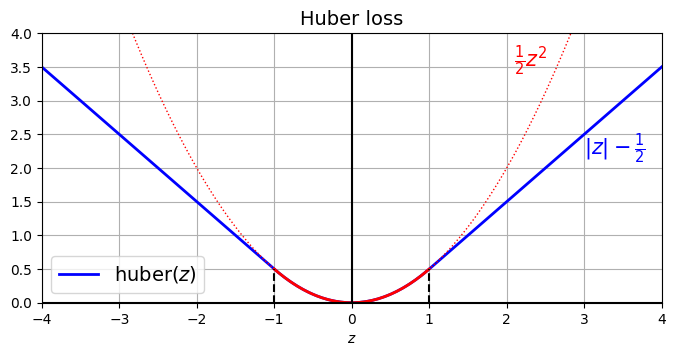

In [78]:
# extra code – shows what the Huber loss looks like

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

To test our custom loss function, let's create a basic Keras model and train it on the California housing dataset:

In [79]:
# extra code – loads, splits and scales the California housing dataset, then
#              creates a simple Keras model

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_shape = X_train.shape[1:]

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [81]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7494 - mae: 1.1371 - val_loss: 0.3474 - val_mae: 0.6522
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2607 - mae: 0.5681 - val_loss: 0.2553 - val_mae: 0.5383


## Saving/Loading Models with Custom Objects

In [82]:
model.save("my_model_with_a_custom_loss.keras")  # extra code – saving works fine

In [83]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss.keras",
                                   custom_objects={"huber_fn": huber_fn})

In [84]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2188 - mae: 0.5096 - val_loss: 0.2129 - val_mae: 0.4876
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1990 - mae: 0.4809 - val_loss: 0.1891 - val_mae: 0.4610


In [85]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [86]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [87]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2148 - mae: 0.4689 - val_loss: 0.2084 - val_mae: 0.4504
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2054 - mae: 0.4597 - val_loss: 0.1807 - val_mae: 0.4340


In [88]:
model.save("my_model_with_a_custom_loss_threshold_2.keras")

In [89]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_threshold_2.keras",
                                   custom_objects={"huber_fn": create_huber(2.0)})

In [90]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2000 - mae: 0.4540 - val_loss: 0.1853 - val_mae: 0.4339
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1959 - mae: 0.4490 - val_loss: 0.1976 - val_mae: 0.4367


In [91]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [92]:
# extra code – creates another basic Keras model
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [93]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [94]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0512 - mae: 1.1438 - val_loss: 0.5086 - val_mae: 0.6718
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3170 - mae: 0.5816 - val_loss: 0.3527 - val_mae: 0.5571


In [95]:
model.save("my_model_with_a_custom_loss_class.keras")  # extra code – saving works

In [96]:
model = tf.keras.models.load_model("my_model_with_a_custom_loss_class.keras",
                                   custom_objects={"HuberLoss": HuberLoss})

In [97]:
# extra code – shows that loading worked fine, the model can be used normally
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2612 - mae: 0.5244 - val_loss: 0.2689 - val_mae: 0.4982
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2328 - mae: 0.4929 - val_loss: 0.2207 - val_mae: 0.4657


In [98]:
model.loss.threshold  # extra code – the treshold was loaded correctly

2.0

## Other Custom Functions

In [99]:
def my_softplus(z):
    return tf.math.log(1.0 + tf.exp(z))

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):  # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [100]:
layer = tf.keras.layers.Dense(1, activation=my_softplus,
                              kernel_initializer=my_glorot_initializer,
                              kernel_regularizer=my_l1_regularizer,
                              kernel_constraint=my_positive_weights)

In [101]:
class MyL1Regularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))

    def get_config(self):
        return {"factor": self.factor}

## Custom Metrics

In [102]:
# extra code – once again, lets' create a basic Keras model
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [103]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [104]:
# extra code – train the model with our custom metric
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - huber_fn: 1.0788 - loss: 2.5942
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - huber_fn: 0.3403 - loss: 0.7644


**Note**: if you use the same function as the loss and a metric, you may be surprised to see slightly different results. This is in part because the operations are not computed exactly in the same order, so there might be tiny floating point errors. More importantly, if you use sample weights or class weights, then the equations are a bit different:
* the `fit()` method keeps track of the mean of all batch losses seen so far since the start of the epoch. Each batch loss is the sum of the weighted instance losses divided by the _batch size_ (not the sum of weights, so the batch loss is _not_ the weighted mean of the losses).
* the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is the weighted mean of all the instance losses. Not the same thing.

### Streaming metrics

In [105]:
precision = tf.keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])

<tf.Tensor: shape=(), dtype=float32, numpy=0.800000011920929>

In [106]:
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [107]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [108]:
precision.variables

[<Variable path=precision/true_positives, shape=(1,), dtype=float32, value=[4.]>,
 <Variable path=precision/false_positives, shape=(1,), dtype=float32, value=[4.]>]

**Warning**: the `reset_states()` method was renamed to `reset_state()`.

In [109]:
precision.reset_state()

Creating a streaming metric:

**Warning**: the `add_weight()` method's argument have a different order now, so we have to specify `name="total"` and `name="count"` rather than just passing the name as the first argument.

In [110]:
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs)  # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        sample_metrics = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(sample_metrics))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

**Extra material** – the rest of this section tests the `HuberMetric` class and shows another implementation subclassing `tf.keras.metrics.Mean`.

In [111]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [112]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [113]:
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [114]:
m.variables

[<Variable path=huber_metric/total, shape=(), dtype=float32, value=21.0>,
 <Variable path=huber_metric/count, shape=(), dtype=float32, value=3.0>]

In [115]:
m.reset_state()
m.variables

[<Variable path=huber_metric/total, shape=(), dtype=float32, value=0.0>,
 <Variable path=huber_metric/count, shape=(), dtype=float32, value=0.0>]

Let's check that the `HuberMetric` class works well:

In [116]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [117]:
model.compile(loss=create_huber(2.0), optimizer="nadam",
              metrics=[HuberMetric(2.0)])

In [118]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - huber_metric_1: 1.0512 - loss: 1.0512
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - huber_metric_1: 0.3170 - loss: 0.3170


In [119]:
model.save("my_model_with_a_custom_metric.keras")

In [120]:
model = tf.keras.models.load_model(
    "my_model_with_a_custom_metric.keras",
    custom_objects={
        "huber_fn": create_huber(2.0),
        "HuberMetric": HuberMetric
    }
)

In [121]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - huber_metric_1: 0.2612 - loss: 0.2612
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - huber_metric_1: 0.2328 - loss: 0.2328


Looks like it works fine! More simply, we could have created the class like this:

In [122]:
class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

This class handles shapes better, and it also supports sample weights.

In [123]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=input_shape),
    tf.keras.layers.Dense(1),
])

In [124]:
model.compile(loss=tf.keras.losses.Huber(2.0), optimizer="nadam",
              weighted_metrics=[HuberMetric(2.0)])

In [125]:
np.random.seed(42)
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2,
                    sample_weight=sample_weight)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - HuberMetric: 1.0599 - loss: 0.5274
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - HuberMetric: 0.3215 - loss: 0.1598


In [126]:
(history.history["loss"][0],
 history.history["HuberMetric"][0] * sample_weight.mean())

(0.3256884217262268, 0.32568849524955656)

In [127]:
model.save("my_model_with_a_custom_metric_v2.keras")

In [128]:
model = tf.keras.models.load_model("my_model_with_a_custom_metric_v2.keras",
                                   custom_objects={"HuberMetric": HuberMetric})

In [129]:
model.fit(X_train_scaled, y_train, epochs=2)

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - HuberMetric: 0.2627 - loss: 0.2262
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - HuberMetric: 0.2298 - loss: 0.1999


## Custom Layers

In [130]:
exponential_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [131]:
# extra code – like all layers, it can be used as a function:
exponential_layer(tf.constant([-1., 0., 1.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

Adding an exponential layer at the output of a regression model can be useful if the values to predict are positive and with very different scales (e.g., 0.001, 10., 10000).

In [132]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    tf.keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2350 - val_loss: 0.4393
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6130 - val_loss: 0.4048
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5169 - val_loss: 0.3940
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4510 - val_loss: 0.3694
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5406 - val_loss: 0.3799
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3955


0.3980194926261902

Alternatively, it's often preferable to replace the targets with the logarithm of the targets (and use no activation function in the output layer).

In [133]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="he_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [134]:
# extra code – shows that a custom layer can be used normally
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)
model.save("my_model_with_a_custom_layer.keras")

Epoch 1/2


<ipython-input-133-72f990369efb>:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.7265 - val_loss: 6.9256
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9550 - val_loss: 2.6011
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7227


In [135]:
# extra code – shows how to load a model with a custom layer
model = tf.keras.models.load_model("my_model_with_a_custom_layer.keras",
                                   custom_objects={"MyDense": MyDense})
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7034 - val_loss: 0.8613
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5803 - val_loss: 0.4588


In [136]:
class MyMultiLayer(tf.keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)  # extra code
        return X1 + X2, X1 * X2, X1 / X2

Our custom layer can be called using the functional API like this:

In [137]:
# extra code – tests MyMultiLayer with symbolic inputs
inputs1 = tf.keras.layers.Input(shape=[2])
inputs2 = tf.keras.layers.Input(shape=[2])
MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


(<KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_44>,
 <KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_45>,
 <KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_46>)

Note that the `call()` method receives symbolic inputs, and it returns symbolic outputs. The shapes are only partially specified at this stage: we don't know the batch size, which is why the first dimension is `None`.

We can also pass actual data to the custom layer:

In [138]:
# extra code – tests MyMultiLayer with actual data
X1, X2 = np.array([[3., 6.], [2., 7.]]), np.array([[6., 12.], [4., 3.]])
MyMultiLayer()((X1, X2))

X1.shape:  (2, 2)  X2.shape:  (2, 2)


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 9., 18.],
        [ 6., 10.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[18., 72.],
        [ 8., 21.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5      , 0.5      ],
        [0.5      , 2.3333333]], dtype=float32)>)

Now let's create a layer with a different behavior during training and testing:

In [139]:
class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

Here's a simple model that uses this custom layer:

In [140]:
# extra code – tests MyGaussianNoise
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    MyGaussianNoise(stddev=1.0, input_shape=input_shape),
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2


<ipython-input-139-0a938d58b22f>:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.7619 - val_loss: 25.1369
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3951 - val_loss: 14.9793
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1219


1.124422311782837

## Custom Models

In [141]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu",
                                             kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [142]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu",
                                             kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

    # extra code - to be able to save and load the model below
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "output_dim": self.output_dim}

In [143]:
# extra code – shows that the model can be used normally
tf.keras.utils.set_random_seed(42)
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
score = model.evaluate(X_test_scaled, y_test)
model.save("my_custom_model.keras")

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 123.5810
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5416
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1639


In [144]:
# extra code – the model can be loaded and you can continue training or use it
#              to make predictions
model = tf.keras.models.load_model(
    "my_custom_model.keras",
    custom_objects={"ResidualRegressor": ResidualRegressor}
)
history = model.fit(X_train_scaled, y_train, epochs=2)
model.predict(X_test_scaled[:3])

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0554
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9670
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


array([[0.7185668],
       [1.1036984],
       [3.9145215]], dtype=float32)

We could have defined the model using the sequential API instead:

In [145]:
tf.keras.utils.set_random_seed(42)
block1 = ResidualBlock(2, 30)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",
                          kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    tf.keras.layers.Dense(1)
])

## Losses Based on Model Internals

**Warning**: the `add_metric()` method was deprecated and removed in recent TF versions. Metrics (custom or not) must now be passed to the model via the `metrics` argument of the `model.compile()` method.

In [157]:
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(30, activation="relu",
                                              kernel_initializer="he_normal")
                       for _ in range(5)]
        self.out = tf.keras.layers.Dense(output_dim)
        # Créer la métrique custom
        self.reconstruction_mean = tf.keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)
        super().build(batch_input_shape)

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        # Ajouter la perte de reconstruction au total des losses du modèle
        self.add_loss(0.05 * recon_loss)
        if training:
            # Mettre à jour l'état de la métrique sans utiliser add_metric()
            self.reconstruction_mean.update_state(recon_loss)
        return self.out(Z)

    @property
    def metrics(self):
        # On ajoute la métrique custom à la liste des métriques suivies
        return super().metrics + [self.reconstruction_mean]


In [158]:
# extra code
tf.keras.utils.set_random_seed(42)
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
y_pred = model.predict(X_test_scaled)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 1.1051 - reconstruction_error: 1.2067
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5082 - reconstruction_error: 0.5382
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4392 - reconstruction_error: 0.4159
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3985 - reconstruction_error: 0.3510
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3805 - reconstruction_error: 0.3269
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Computing Gradients Using Autodiff

In [159]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [160]:
w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [161]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [162]:
w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

In [163]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [164]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
try:
    dz_dw2 = tape.gradient(z, w2)  # raises a RuntimeError!
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [165]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 36.0
dz_dw2 = tape.gradient(z, w2)  # returns tensor 10.0, works fine now!
del tape

In [166]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [167]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [168]:
gradients

[None, None]

In [169]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])

In [170]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [171]:
# extra code – if given a vector, tape.gradient() will compute the gradient of
#              the vector's sum.
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [172]:
# extra code – shows that we get the same result as the previous cell
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    z = z1 + z2 + z3

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [173]:
# extra code – shows how to compute the jacobians and the hessians
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [174]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [175]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [176]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)  # same result as without stop_gradient()

gradients = tape.gradient(z, [w1, w2])

In [177]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [178]:
x = tf.Variable(1e-50)
with tf.GradientTape() as tape:
    z = tf.sqrt(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=inf>]

In [179]:
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [180]:
x = tf.Variable([1.0e30])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [181]:
def my_softplus(z):
    return tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)

Here is the proof that this equation is equal to log(1 + exp(_z_)):
* softplus(_z_) = log(1 + exp(_z_))
* softplus(_z_) = log(1 + exp(_z_)) - log(exp(_z_)) + log(exp(_z_)) ; **just adding and subtracting the same value**
* softplus(_z_) = log\[(1 + exp(_z_)) / exp(_z_)\] + log(exp(_z_)) ; **since log(_a_) - log(_b_) = log(_a_ / _b_)**
* softplus(_z_) = log\[(1 + exp(_z_)) / exp(_z_)\] + _z_ ; **since log(exp(_z_)) = _z_**
* softplus(_z_) = log\[1 / exp(_z_) + exp(_z_) / exp(_z_)\] + _z_ ; **since (1 + _a_) / _b_ = 1 / _b_ + _a_ / _b_**
* softplus(_z_) = log\[exp(–_z_) + 1\] + _z_ ; **since 1 / exp(_z_) = exp(–z), and exp(_z_) / exp(_z_) = 1**
* softplus(_z_) = softplus(–_z_) + _z_ ; **we recognize the definition at the top, but with –_z_**
* softplus(_z_) = softplus(–|_z_|) + max(0, _z_) ; **if you consider both cases, _z_ < 0 or _z_ ≥ 0, you will see that this works**

In [182]:
@tf.custom_gradient
def my_softplus(z):
    def my_softplus_gradients(grads):  # grads = backprop'ed from upper layers
        return grads * (1 - 1 / (1 + tf.exp(z)))  # stable grads of softplus

    result = tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)
    return result, my_softplus_gradients

In [183]:
# extra code – shows that the function is now stable, as well as its gradients
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

## Custom Training Loops

In [184]:
tf.keras.utils.set_random_seed(42)  # extra code – to ensure reproducibility
l2_reg = tf.keras.regularizers.l2(0.05)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          kernel_regularizer=l2_reg),
    tf.keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [185]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [186]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}"
                          for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end)

In [187]:
tf.keras.utils.set_random_seed(42)

**Warning**: the `tf.keras.losses.mean_squared_error()` function not longer exists, you must use `tf.keras.losses.MeanSquaredError` class instead.

In [188]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [189]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train) # On génère un mini-batch
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True) # Calcul la sortie du modèle avec les valeurs du mini-batch
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred)) # On calcule la perte entre les cibles réelles et la sortie obtenue puis on prend la moyenne de ces pertes qui servira dans la retropropagation pour ajuster les param du modèle
            loss = tf.add_n([main_loss] + model.losses) # On ajoute a la perte obtenue les pertes additionnelles du modèles tels que la régularisation

        gradients = tape.gradient(loss, model.trainable_variables) # On calcule les gradients de la fonction de perte en fonction des paramètres entraînables du modèle
        optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # On met à jour les poids du modèle en utilisant l'optimiseur choisi

        # extra code – if your model has variable constraints
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))

        mean_loss(loss) # mise a jour de la métrique qui suit la moyenne de la perte sur les step de l'epoch en cours
        for metric in metrics: # On appelle chaque metrique défini en lui passant les valeurs réelles et les valeurs prédites
            metric(y_batch, y_pred)

        print_status_bar(step, n_steps, mean_loss, metrics) # Affichage du status de l'epoch

    for metric in [mean_loss] + metrics: # A la fin d'une epoch on reset l'état de toute nos metrics
        metric.reset_state()

Epoch 1/5
362/362 - mean: 3.5419 - mean_absolute_error: 0.6640
Epoch 2/5
362/362 - mean: 1.8693 - mean_absolute_error: 0.5431
Epoch 3/5
362/362 - mean: 1.1428 - mean_absolute_error: 0.5030
Epoch 4/5
362/362 - mean: 0.8501 - mean_absolute_error: 0.4977
Epoch 5/5
362/362 - mean: 0.7280 - mean_absolute_error: 0.5014


In [ ]:
# extra code – shows how to use the tqdm package to display nice progress bars

from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train_scaled, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)

        for metric in [mean_loss] + metrics:
            metric.reset_state()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]

## TensorFlow Functions

In [ ]:
def cube(x):
    return x ** 3

In [ ]:
cube(2)

8

In [ ]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
tf_cube = tf.function(cube)
tf_cube

In [ ]:
tf_cube(2)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [ ]:
tf_cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
@tf.function
def tf_cube(x):
    return x ** 3

**Note:** the rest of the code in this section is in appendix D.

### TF Functions and Concrete Functions

In [ ]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))
concrete_function

<ConcreteFunction tf_cube(x) at 0x19F90F400>

In [ ]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
concrete_function is tf_cube.get_concrete_function(tf.constant(2.0))

True

### Exploring Function Definitions and Graphs

In [ ]:
concrete_function.graph

PyGraph<6956689888>

In [ ]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [ ]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [ ]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [ ]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [ ]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [ ]:
concrete_function.function_def.signature

name: "__inference_tf_cube_592407"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

### How TF Functions Trace Python Functions to Extract Their Computation Graphs

In [ ]:
@tf.function
def tf_cube(x):
    print(f"x = {x}")
    return x ** 3

In [ ]:
result = tf_cube(tf.constant(2.0))

x = Tensor("x:0", shape=(), dtype=float32)


In [ ]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [ ]:
result = tf_cube(2)

x = 2


In [ ]:
result = tf_cube(3)

x = 3


In [ ]:
result = tf_cube(tf.constant([[1., 2.]]))  # New shape: trace!

x = Tensor("x:0", shape=(1, 2), dtype=float32)


In [ ]:
result = tf_cube(tf.constant([[3., 4.], [5., 6.]]))  # New shape: trace!

x = Tensor("x:0", shape=(2, 2), dtype=float32)


In [ ]:
result = tf_cube(tf.constant([[7., 8.], [9., 10.]]))  # Same shape: no trace

It is also possible to specify a particular input signature:

In [ ]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)  # extra code to show when tracing happens
    return images[:, ::2, ::2] # drop half the rows and columns

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1)  # Works fine, traces the function
preprocessed_images = shrink(img_batch_2)  # Works fine, same concrete function

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [ ]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # TypeError! Incompatible inputs
except TypeError as ex:
    print(ex)

Binding inputs to tf.function `shrink` failed due to `Can not cast TensorSpec(shape=(2, 2, 2), dtype=tf.float32, name=None) to TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)`. Received args: (<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[0.7413678 , 0.62854624],
        [0.01738465, 0.3431449 ]],

       [[0.51063764, 0.3777541 ],
        [0.07321596, 0.02137029]]], dtype=float32)>,) and kwargs: {} for signature: (images: TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None)).


### Using Autograph To Capture Control Flow

A "static" `for` loop using `range()`:

In [ ]:
@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

In [ ]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [ ]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" loop using `tf.while_loop()`:

In [ ]:
# extra code – shows how to use tf.while_loop (usually @tf.function is simpler)
@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

In [ ]:
add_10(tf.constant(5))

<tf.Tensor: shape=(), dtype=int32, numpy=15>

In [ ]:
add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

A "dynamic" `for` loop using `tf.range()` (captured by autograph):

In [ ]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

In [ ]:
add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'sub' type=Sub>,
 <tf.Operation 'floordiv' type=FloorDiv>,
 <tf.Operation 'mod' type=FloorMod>,
 <tf.Operation 'zeros_like' type=Const>,
 <tf.Operation 'NotEqual' type=NotEqual>,
 <tf.Operation 'Cast' type=Cast>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'zeros_like_1' type=Const>,
 <tf.Operation 'Maximum' type=Maximum>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

### Handling Variables and Other Resources in TF Functions

In [ ]:
counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

increment(counter)  # counter is now equal to 1
increment(counter)  # counter is now equal to 2

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [ ]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

In [ ]:
increment()
increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [ ]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

In [ ]:
c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



In [ ]:
# extra code – shows how to display the autograph code with syntax highlighting
def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown(f'```python\n{code}\n```'))

In [ ]:
display_tf_code(add_10)

```python
def tf__add(x):
    with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def loop_body(itr):
            nonlocal x
            i = itr
            x = ag__.ld(x)
            x += 1
        i = ag__.Undefined('i')
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (10,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': 'i'})
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

```

## Using TF Functions with tf.keras (or Not)

By default, tf.keras will automatically convert your custom code into TF Functions, no need to use
`tf.function()`:

In [ ]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [ ]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [ ]:
# Custom layer
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias',
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
# Custom model
class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
315/363 [=========================>....] - ETA: 0s - loss: 1.5746 - my_mae: 0.8719Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
363/363 [==============================] - 1s 1ms/step - loss: 1.4303 - my_mae: 0.8219 - val_loss: 0.4932 - val_my_mae: 0.4764
Epoch 2/2
162/162 [==============================] - 0s 704us/step - loss: 0.4204 - my_mae: 0.4711


[0.4203692376613617, 0.4711270332336426]

You can turn this off by creating the model with `dynamic=True` (or calling `super().__init__(dynamic=True, **kwargs)` in the model's constructor):

In [ ]:
tf.keras.utils.set_random_seed(42)

**Warning**: the `dynamic` argument no longer exists since Keras 3. However, you can still compile a model with `run_eagerly=True`:

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
model = MyModel()

In [ ]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

In [ ]:
model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.545090198516846, 2.0603599548339844]

## Extra Material – Custom Optimizers

The Keras API to create a custom optimizer has changed since Keras 3, so if you need to create one, I recommend you draw inspiration from the source code of one of Keras's builtin optimizers, such as [SGD](https://github.com/keras-team/keras/blob/b083f2e95d4d6b09f6ec22717fd1becccbdbcec1/keras/src/optimizers/sgd.py#L7)

# Exercises

## 1. to 11.

1. TensorFlow is an open-source library for numerical computation, particularly well suited and fine-tuned for large-scale Machine Learning. Its core is similar to NumPy, but it also features GPU support, support for distributed computing, computation graph analysis and optimization capabilities (with a portable graph format that allows you to train a TensorFlow model in one environment and run it in another), an optimization API based on reverse-mode autodiff, and several powerful APIs such as tf.keras, tf.data, tf.image, tf.signal, and more. Other popular Deep Learning libraries include PyTorch, MXNet, Microsoft Cognitive Toolkit, Theano, Caffe2, and Chainer.
2. Although TensorFlow offers most of the functionalities provided by NumPy, it is not a drop-in replacement, for a few reasons. First, the names of the functions are not always the same (for example, `tf.reduce_sum()` versus `np.sum()`). Second, some functions do not behave in exactly the same way (for example, `tf.transpose()` creates a transposed copy of a tensor, while NumPy's `T` attribute creates a transposed view, without actually copying any data). Lastly, NumPy arrays are mutable, while TensorFlow tensors are not (but you can use a `tf.Variable` if you need a mutable object).
3. Both `tf.range(10)` and `tf.constant(np.arange(10))` return a one-dimensional tensor containing the integers 0 to 9. However, the former uses 32-bit integers while the latter uses 64-bit integers. Indeed, TensorFlow defaults to 32 bits, while NumPy defaults to 64 bits.
4. Beyond regular tensors, TensorFlow offers several other data structures, including sparse tensors, tensor arrays, ragged tensors, queues, string tensors, and sets. The last two are actually represented as regular tensors, but TensorFlow provides special functions to manipulate them (in `tf.strings` and `tf.sets`).
5. When you want to define a custom loss function, in general you can just implement it as a regular Python function. However, if your custom loss function must support some hyperparameters (or any other state), then you should subclass the `keras.losses.Loss` class and implement the `__init__()` and `call()` methods. If you want the loss function's hyperparameters to be saved along with the model, then you must also implement the `get_config()` method.
6. Much like custom loss functions, most metrics can be defined as regular Python functions. But if you want your custom metric to support some hyperparameters (or any other state), then you should subclass the `keras.metrics.Metric` class. Moreover, if computing the metric over a whole epoch is not equivalent to computing the mean metric over all batches in that epoch (e.g., as for the precision and recall metrics), then you should subclass the `keras.metrics.Metric` class and implement the `__init__()`, `update_state()`, and `result()` methods to keep track of a running metric during each epoch. You should also implement the `reset_state()` method unless all it needs to do is reset all variables to 0.0. If you want the state to be saved along with the model, then you should implement the `get_config()` method as well.
7. You should distinguish the internal components of your model (i.e., layers or reusable blocks of layers) from the model itself (i.e., the object you will train). The former should subclass the `keras.layers.Layer` class, while the latter should subclass the `keras.models.Model` class.
8. Writing your own custom training loop is fairly advanced, so you should only do it if you really need to. Keras provides several tools to customize training without having to write a custom training loop: callbacks, custom regularizers, custom constraints, custom losses, and so on. You should use these instead of writing a custom training loop whenever possible: writing a custom training loop is more error-prone, and it will be harder to reuse the custom code you write. However, in some cases writing a custom training loop is necessary⁠—for example, if you want to use different optimizers for different parts of your neural network, like in the [Wide & Deep paper](https://homl.info/widedeep). A custom training loop can also be useful when debugging, or when trying to understand exactly how training works.
9. Custom Keras components should be convertible to TF Functions, which means they should stick to TF operations as much as possible and respect all the rules listed in Chapter 12 (in the _TF Function Rules_ section). If you absolutely need to include arbitrary Python code in a custom component, you can either wrap it in a `tf.py_function()` operation (but this will reduce performance and limit your model's portability) or set `dynamic=True` when creating the custom layer or model (or set `run_eagerly=True` when calling the model's `compile()` method).
10. Please refer to Chapter 12 for the list of rules to respect when creating a TF Function (in the _TF Function Rules_ section).
11. Creating a dynamic Keras model can be useful for debugging, as it will not compile any custom component to a TF Function, and you can use any Python debugger to debug your code. It can also be useful if you want to include arbitrary Python code in your model (or in your training code), including calls to external libraries. To make a model dynamic, you must set `dynamic=True` when creating it. Alternatively, you can set `run_eagerly=True` when calling the model's `compile()` method. Making a model dynamic prevents Keras from using any of TensorFlow's graph features, so it will slow down training and inference, and you will not have the possibility to export the computation graph, which will limit your model's portability.

## 12. Implement a custom layer that performs _Layer Normalization_
_We will use this type of layer in Chapter 15 when using Recurrent Neural Networks._

### a.
_Exercise: The `build()` method should define two trainable weights *α* and *β*, both of shape `input_shape[-1:]` and data type `tf.float32`. *α* should be initialized with 1s, and *β* with 0s._

Solution: see below.

### b.
_Exercise: The `call()` method should compute the mean_ μ _and standard deviation_ σ _of each instance's features. For this, you can use `tf.nn.moments(inputs, axes=-1, keepdims=True)`, which returns the mean μ and the variance σ<sup>2</sup> of all instances (compute the square root of the variance to get the standard deviation). Then the function should compute and return *α*⊗(*X* - μ)/(σ + ε) + *β*, where ⊗ represents itemwise multiplication (`*`) and ε is a smoothing term (small constant to avoid division by zero, e.g., 0.001)._

In [ ]:
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, eps=0.001, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps

    def build(self, batch_input_shape):
        self.alpha = self.add_weight(
            name="alpha", shape=batch_input_shape[-1:],
            initializer="ones")
        self.beta = self.add_weight(
            name="beta", shape=batch_input_shape[-1:],
            initializer="zeros")

    def call(self, X):
        mean, variance = tf.nn.moments(X, axes=-1, keepdims=True)
        return self.alpha * (X - mean) / (tf.sqrt(variance + self.eps)) + self.beta

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "eps": self.eps}

Note that making _ε_ a hyperparameter (`eps`) was not compulsory. Also note that it's preferable to compute `tf.sqrt(variance + self.eps)` rather than `tf.sqrt(variance) + self.eps`. Indeed, the derivative of sqrt(z) is undefined when z=0, so training will bomb whenever the variance vector has at least one component equal to 0. Adding _ε_ within the square root guarantees that this will never happen.

### c.
_Exercise: Ensure that your custom layer produces the same (or very nearly the same) output as the `tf.keras.layers.LayerNormalization` layer._

Let's create one instance of each class, apply them to some data (e.g., the training set), and ensure that the difference is negligeable.

**Warning**: the `mean_absolute_error()` function no longer exists. Instead, you must use the `MeanAbsoluteError` class.

In [ ]:
X = X_train.astype(np.float32)

custom_layer_norm = LayerNormalization()
keras_layer_norm = tf.keras.layers.LayerNormalization()

tf.reduce_mean(tf.keras.losses.MeanAbsoluteError()(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=3.9782837e-08>

Yep, that's close enough. To be extra sure, let's make alpha and beta completely random and compare again:

In [ ]:
tf.keras.utils.set_random_seed(42)
random_alpha = np.random.rand(X.shape[-1])
random_beta = np.random.rand(X.shape[-1])

custom_layer_norm.set_weights([random_alpha, random_beta])
keras_layer_norm.set_weights([random_alpha, random_beta])

tf.reduce_mean(tf.keras.losses.MeanAbsoluteError()(
    keras_layer_norm(X), custom_layer_norm(X)))

<tf.Tensor: shape=(), dtype=float32, numpy=1.764704e-08>

Still a negligeable difference! Our custom layer works fine.

## 13. Train a model using a custom training loop to tackle the Fashion MNIST dataset
_The Fashion MNIST dataset was introduced in Chapter 10._

### a.
_Exercise: Display the epoch, iteration, mean training loss, and mean accuracy over each epoch (updated at each iteration), as well as the validation loss and accuracy at the end of each epoch._

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_state()


All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

### b.
_Exercise: Try using a different optimizer with a different learning rate for the upper layers and the lower layers._

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
lower_layers = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
])
upper_layers = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="softmax"),
])
model = tf.keras.Sequential([
    lower_layers, upper_layers
])

In [ ]:
lower_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
upper_optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(X_train, y_train)
                with tf.GradientTape(persistent=True) as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)
                for layers, optimizer in ((lower_layers, lower_optimizer),
                                          (upper_layers, upper_optimizer)):
                    gradients = tape.gradient(loss, layers.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, layers.trainable_variables))
                del tape
                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))
                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()
                steps.set_postfix(status)
            y_pred = model(X_valid)
            status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
            status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
                tf.constant(y_valid, dtype=np.float32), y_pred))
            steps.set_postfix(status)
        for metric in [mean_loss] + metrics:
            metric.reset_state()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]